# Random Forest regression analysis of Ge in combined OSNACA data

In [94]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [95]:
#read in the data

osnaca = pd.read_excel("../data/osnaca-data.xlsx",sheet_name="Data")
osnaca_conclurry = pd.read_excel("../data/osnaca-data.xlsx",sheet_name="Cloncurry Supplement")
osnaca_metadata_sheet1 = pd.read_excel("../data/osnaca-metadata.xlsx",sheet_name="Ore samples")

In [96]:
osnaca.head()

,Sample,Code,Au (FA),Pt,Pd,Au (AR),Bi,Te,Hg,Ag,...,Y,Zn,B,Hf,Si,Zr,Be,Ga,Ge,Wt Tot
0,700001,NaN,0.438,0.002,0.002,0.362,10.60,0.02,0.39,91.5,...,1.2,153000,-20,0.4,34200,60,-1.0,11.0,1,159
1,700002,NaN,0.093,0.001,0.002,0.095,125.00,0.22,0.12,44.0,...,18.5,3780,-20,0.2,114000,20,-1.0,2.0,-1,143
2,700003,NaN,1.41,0.002,0.002,1.39,120.00,0.02,62.9,215.0,...,0.3,219000,-20,-0.2,71500,-10,-1.0,-1.0,2,204
3,700004,1,0.096,0.003,0.005,0.086,0.72,0.80,0.03,2.5,...,6.3,755,-20,2.0,244000,70,-1.0,-1.0,-1,185
4,700005,NaN,2.9,0.003,0.005,3.94,0.34,0.06,4.01,162.0,...,4.5,173000,-20,-0.2,142000,-10,-1.0,-1.0,2,280


In [97]:
osnaca_conclurry.head()

,Sample,Code,Code Tester,Au1,Pt,Pd,Au(AR),Bi,Te,Hg,...,Y,Zn,B,Hf,Si,Zr,Be,Ga,Ge,Wt Total
0,ALT010,NaN,NaN,0.039,0.002,-0.001,NaN,1.20,0.44,12.80,...,7.1,6760,-20,1.2,91800,40,4.2,16.6,4,164.0
1,ALT024,NaN,NaN,0.011,-0.001,0.002,NaN,0.20,0.10,0.02,...,14.6,1390,-20,22.0,64300,900,12.2,25.8,3,140.0
2,ALT073,NaN,NaN,0.436,0.004,0.007,NaN,0.30,0.22,1.30,...,15.1,1510,-20,2.0,127000,70,17.0,32.4,12,109.0
3,ALT074,NaN,NaN,0.508,0.002,0.002,NaN,24.70,1.80,3.91,...,3.6,14500,20,0.4,40300,4,0.9,5.6,1,NaN
4,ART013,1.0,1.0,-0.001,0.001,-0.001,NaN,0.08,-0.02,-0.01,...,41.0,225,80,5.6,248000,156,6.0,33.4,1,NaN


### Merge two first sheets

In [98]:
set(osnaca.columns).difference(set(osnaca_conclurry.columns))

{'Au (AR)', 'Au (FA)', 'Wt Tot'}

In [99]:
set(osnaca_conclurry.columns).difference(set(osnaca.columns))

{'Au(AR)', 'Au1', 'Code Tester', 'Wt Total'}

In [100]:
#assumed Au1 = Au (FA)
osnaca_cloncurry = osnaca_conclurry.rename(columns={"Wt Total": "Wt Tot", "Au(AR)": "Au (AR)", "Au1": "Au (FA)"})
osnaca_cloncurry = osnaca_cloncurry.drop(['Code Tester'], axis = 1)

In [101]:
#merge the Cloncurry data with the other samples
osnaca_all = pd.concat([osnaca, osnaca_cloncurry]) 

In [102]:
#conclurry rows successfully contatenated
print(osnaca.shape, osnaca_cloncurry.shape, osnaca_all.shape)

(1139, 69) (72, 69) (1211, 69)


Highest Associates of Ge appear to be Zn, Cd, S and Tl as seen below in both combined and single dataset

In [103]:
#using combined dataset doesn't notably change correlations with Ge at first glance
osnaca_all.corr()['Ge'].sort_values(ascending=False)

Ge    1.000000
Zn    0.496282
Cd    0.226739
S     0.198342
Tl    0.179400
        ...   
K    -0.095798
Na   -0.102637
Ti   -0.116100
Al   -0.139017
Si   -0.185344
Name: Ge, Length: 61, dtype: float64

In [104]:
osnaca.corr()['Ge'].sort_values(ascending=False)

Ge    1.000000
Zn    0.494664
Cd    0.224266
S     0.202368
Tl    0.177224
        ...   
K    -0.098204
Na   -0.103530
Ti   -0.119651
Al   -0.143311
Si   -0.195223
Name: Ge, Length: 62, dtype: float64

## Data Cleaning

Remove Na values for RF regressor

Deal with negative values, by converting it to half the absolute value

In [105]:
#missing values need to be removed, Code and Wt Tot columnns can be removed as they aren't useful features, meaning 72 rows will be removed
osnaca_all.isna().sum()[osnaca_all.isna().sum() > 0]

Code       994
Au (AR)     72
Wt Tot     617
dtype: int64

In [106]:
#drop code and wt tot columns
#drop sample column as it is not a useful feature
osnaca_all2 = osnaca_all.drop(['Code', 'Wt Tot', 'Sample'], axis=1)
osnaca_all2.isna().sum()[osnaca_all2.isna().sum() > 0]

Au (AR)    72
dtype: int64

In [107]:
#remove values that are 'IS'
osnaca_all2=osnaca_all2[osnaca_all2 != 'IS']

C:\Users\caley\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [108]:
#drop 72 rows
osnaca_all2 = osnaca_all2.dropna()
osnaca_all2.isna().sum()[osnaca_all2.isna().sum() > 0]

Series([], dtype: int64)

In [109]:

#osnaca_all2[osnaca_all2 < 0] = 0

#convert object type columns to numeric
osnaca_all2=osnaca_all2.apply(pd.to_numeric, errors = 'coerce')

#convert negative values to half their absolute value
osnaca_all2[osnaca_all2 <0] = abs(osnaca_all2[osnaca_all2 < 0])/2

In [110]:
#1135 rows remain
osnaca_all2.shape

(1135, 66)

## Random Forest

In [111]:
from sklearn.ensemble import RandomForestRegressor


#split dataset into features and output variable
X = osnaca_all2.drop(['Ge'], axis=1)
y = osnaca_all2['Ge']

In [112]:
#split data into train and test set
import sklearn.model_selection as selection

X_train, X_test, y_train, y_test = selection.train_test_split(X, y, test_size = 0.25, random_state = 0)

In [113]:
#specify regression model
regressor = RandomForestRegressor(n_estimators=500, max_depth=10, max_features=15, min_samples_leaf=2, random_state=0, bootstrap=True, oob_score=True)


In [114]:
#fit to training data 
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=15, min_samples_leaf=2,
                      n_estimators=500, oob_score=True, random_state=0)

In [115]:
#predictions for training and test data set
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)


### Random Forest Error

In [116]:
#evaluating random forest
from sklearn import metrics
print('Training Error')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train,y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train,y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_train)))
print("")

print('Testing Error')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred_test)))

Training Error
Mean Absolute Error: 2.8390897376373077
Mean Squared Error: 85.28726292277237
Root Mean Squared Error: 9.23511033625329

Testing Error
Mean Absolute Error: 4.8647282234551135
Mean Squared Error: 113.96636157328967
Root Mean Squared Error: 10.675502872150318


## Multiple linear regression

In [117]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression().fit(X_train,y_train)

#predictions for training and test data set
y_pred_trainlr = LR.predict(X_train)
y_pred_testlr = LR.predict(X_test)

### Linear Regression Error

In [118]:


print('Training Error')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train,y_pred_trainlr))
print('Mean Squared Error:', metrics.mean_squared_error(y_train,y_pred_trainlr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train,y_pred_trainlr)))
print("")

print('Testing Error')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred_testlr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred_testlr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred_testlr)))

Training Error
Mean Absolute Error: 6.043157126477861
Mean Squared Error: 287.43539524102766
Root Mean Squared Error: 16.95391976036892

Testing Error
Mean Absolute Error: 6.622167626282977
Mean Squared Error: 184.74743865980713
Root Mean Squared Error: 13.592182998319554


## Feature Importances

In [119]:
#Feature importances
for name, score in zip(X_train.columns, regressor.feature_importances_):
    print(name, score)

Au (FA) 0.02518811482992209
Pt 0.0003561313109000629
Pd 0.0022656890831041594
Au (AR) 0.02068373721226077
Bi 0.028539120333063862
Te 0.004900785411430316
Hg 0.02857287291127515
Ag 0.013877078180563343
Al 0.013601258116498531
As 0.009859702175563603
Ca 0.014492771524392368
Cd 0.08076996184248096
Co 0.016594456573041053
Cr 5.758211992697197e-05
Cs 0.017226317346687413
Cu 0.02524966568379581
Fe 0.011168986103866407
In 0.0066993095747642445
K 0.009329423607910212
La 0.014044253267727314
Ce 0.018729019147203443
Pr 0.00480097733644558
Nd 0.023034994316658224
Sm 0.012921339260530256
Eu 0.005369518386867835
Gd 0.004643478696960591
Tb 0.0010796160465298724
Dy 0.00881056419259515
Ho 0.0031834647149076166
Er 0.0027062874982744438
Tm 0.003731102065686296
Yb 0.004194241928695061
Lu 0.002667114964328535
Li 0.005891738063527575
Mg 0.00797805052534712
Mn 0.014575226144573282
Mo 0.008876626175536697
Na 0.0055276164489826115
Nb 0.001738010362236178
Ni 0.005424750955274533
P 0.0048355297762402594
Pb 0.02

In [120]:
#create sorted dataframe of feature importances
data = {'Feature':X_train.columns,'Importance':regressor.feature_importances_}

featimp = pd.DataFrame(data)
featsorted = featimp.sort_values(by='Importance', ascending=False)
print(featsorted[:20])

    Feature  Importance
58       Zn    0.200545
11       Cd    0.080770
61       Si    0.071928
53       Tl    0.038449
6        Hg    0.028573
4        Bi    0.028539
41       Pb    0.027738
15       Cu    0.025250
0   Au (FA)    0.025188
22       Nd    0.023035
3   Au (AR)    0.020684
20       Ce    0.018729
64       Ga    0.018404
44        S    0.017462
14       Cs    0.017226
12       Co    0.016594
45       Sb    0.015895
35       Mn    0.014575
10       Ca    0.014493
56        W    0.014477


## Visualising Predictions

In [121]:
# Visualising some predictions for train set

# model predictions
xt = X_train[:50]
pred1 = regressor.predict(xt)

In [122]:
#true values
xt_test = np.array(y_train[:50])
xt_test

array([ 2. ,  1. ,  4. ,  0.5,  2. , 14. , 20. , 46. ,  0.5,  3. ,  0.5,
        2. ,  2. ,  3. ,  2. ,  3. ,  3. ,  4. ,  0.5,  3. ,  4. ,  2. ,
       43. ,  1. ,  2. ,  1. ,  1. ,  3. ,  2. , 67. ,  2. ,  6. ,  3. ,
        1. ,  1. ,  0.5,  2. ,  3. , 83. ,  1. ,  6. ,  5. ,  1. ,  0.5,
        2. , 30. ,  1. , 55. ,  0.5,  3. ])

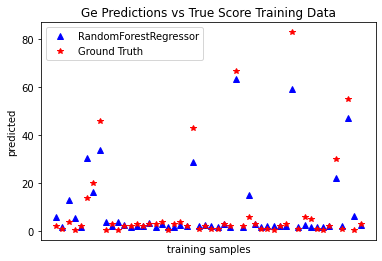

In [123]:
plt.figure()
plt.plot(pred1, 'b^', label = 'RandomForestRegressor')
plt.plot(xt_test, 'r*', label = 'Ground Truth')

plt.tick_params(axis='x', which = 'both', bottom = False, top=False, labelbottom=False)

plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc='best')
plt.title('Ge Predictions vs True Score Training Data')
plt.show()

In [124]:
#visualisation for test predictions

#test predictions
xt = X_test[:50]
pred1 = regressor.predict(xt)

xt_test = np.array(y_test[:50])

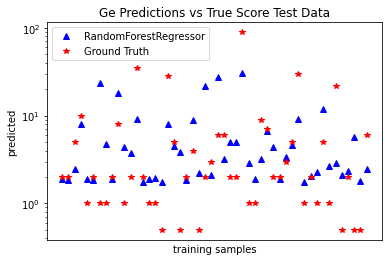

In [125]:
plt.figure()
plt.plot(pred1, 'b^', label = 'RandomForestRegressor')
plt.plot(xt_test, 'r*', label = 'Ground Truth')

plt.tick_params(axis='x', which = 'both', bottom = False, top=False, labelbottom=False)

plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc='best')
plt.yscale('log')
plt.title('Ge Predictions vs True Score Test Data')
plt.show()